In [1]:
import pandas as pd
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

from scipy.optimize import minimize

import sys
sys.path.insert(0, '../scripts/')
import utils as utl
from logistic_regression import LogisticRegression

## Predict

In [2]:
# def log_reg_predict(w, X):
#     return (w*X).sum(axis=1)

## Metrics

In [3]:
# def confusion_matrix(y: pd.Series, y_p: pd.Series) -> np.array:
#     """Calculates the confusion matrix of a classification model

#     Parameters
#     ----------
#     y : pd.Series
#         True values
#     y_p : pd.Series
#         Predicted values

#     Returns
#     -------
#     np.array
#         Confusion Matrix
#     """
#     cats = y.unique()
#     n= len(cats)
#     conf_matr = np.zeros((n,n))

#     for i in range(len(y)):
#         k = np.where(cats == y.iloc[i])[0][0]
#         l = np.where(cats == y_p.iloc[i])[0][0]
#         conf_matr[k][l] = conf_matr[k][l] + 1
#     return conf_matr

In [4]:
# def accuracy_classification(cm: np.array) -> float:
#     """Correct predictions vs total number of data points

#     Parameters
#     ----------
#     cm : np.array
#         Confusion Matrix

#     Returns
#     -------
#     float
#         Accuracy
#     """
#     return cm.trace()/cm.sum()

# def presicion_classification(cm: np.array, i: int = 0) -> float:    
#     """True Positives of a given category vs total number of data points

#     Parameters
#     ----------
#     cm : np.array
#         Multiclass confusion matrix
#     i : int, optional
#         Index of category of interests, by default 0

#     Returns
#     -------
#     float
#         _description_
#     """
#     return cm[i][i]/cm[i].sum()

# def recall_classification(cm: np.array, i: int = 0) -> float:    
#     """True Positives of a given category vs total number of data points

#     Parameters
#     ----------
#     cm : np.array
#         Multiclass confusion matrix
#     i : int, optional
#         Index of category of interests, by default 0

#     Returns
#     -------
#     float
#         _description_
#     """
#     return cm[i][i]/cm[:,i].sum()

In [5]:
# def fbeta_classification(cm: np.array, i: int = 0, beta: float = 1.0) -> float:
#     p = presicion_classification(cm, i=i)
#     r = recall_classification(cm, i=i)
#     fb = 0
#     den = ((beta**2)*p+r)
#     if den !=0:
#         fb = (1+beta**2)*p*r/((beta**2)*p+r)
#     return fb

# Cost functions

In [6]:
# def log_cost_function(w: np.array, X: np.array, y: np.array) -> float:
#     """Calculates the log cost function for binary logistic regression

#     Parameters
#     ----------
#     w : np.array
#         Weights
#     X : np.array
#         Input values
#     y : np.array
#         Expected outputs

#     Returns
#     -------
#     float
#         Logistic cost function result
#     """
#     y_pred = log_reg_predict(w, X)
#     y_pred = utl.min_max_scaling(pd.Series(y_pred))[0]
#     den = 1 + np.exp(y_pred)
#     den[den == 0] = 1e-4
#     h = 1/den
#     return - (1/len(X))*np.sum(y*np.log(h) + (1-y)*np.log(1-h))

In [7]:
# def lcf_for_min(w: np.array, *args: Tuple[np.array, np.array]) -> float:
#     """Calculates the log cost function for binary logistic regression in format necessary for minimization algorithm

#     Parameters
#     ----------
#     w : np.array
#         _description_

#     **args: Tuple[np.array, np.array]
#         np.array: Input values X
#         np.array: Expected outputs y
#     Returns
#     -------
#     float
#         Logistic cost function result
#     """
#     X = args[0]
#     y = args[1]
#     return log_cost_function(w, X, y)

## Class

In [8]:
# class LogisticRegression:
#     def __init__(self) -> None:
#         self.w = None
#         self.y_res = None

#     def fit(self, X: pd.DataFrame, y: pd.Series, bias: float = 0, w: np.array = None):
#         """fit X data towards y target using multiclass logistic regression

#         Parameters
#         ----------
#         X : pd.DataFrame
#             Independent data
#         y : pd.Series
#             Target data
#         bias : float, optional
#             Constant vertical shift, by default 0
#         w : np.array, optional
#             Initial guess of the weights, by default all ones                     
#         """              
#         if w is None:
#             w = np.ones(X.shape[1]+1)

#         y_res = pd.DataFrame()
#         for cat in y.unique():
#             y_np = y.copy().to_numpy()
#             y_np[y_np!=cat]=-1
#             y_np[y_np==cat]=1
#             y_np[y_np==-1]=0
#             y_res[cat] = y_np

#         X_mod = LogisticRegression.add_bias_column(X)
#         X_np = X_mod.to_numpy()

#         # Inicializes data
#         J = np.ones(len(y_res.columns))
#         w_df = pd.DataFrame()
#         for i,val in enumerate(y_res.columns):
#             w_df[val] = 0.1*np.ones(X.shape[1]+1)
#         w = w_df.to_numpy()
#         y_c = y_res.to_numpy()

#         # Minimizes the cost function
#         for i,val in enumerate(y_res.columns):
#             res = minimize(lcf_for_min, w[:,i], args=(X_np, y_c[:,i]))
#             w[:,i] = res.x        
#         self.w = w
#         self.y_res = y_res

#     def predict(self, X: np.array) -> np.array:
#         """Predicts resulting categories based on input data X

#         Parameters
#         ----------
#         X : np.array
#             Input data

#         Returns
#         -------
#         np.array
#             Predicted categories
#         """
#         X_mod = LogisticRegression.add_bias_column(X)
#         X_np = X_mod.to_numpy()

#         # Predictions
#         y_pred = pd.DataFrame()

#         for i,val in enumerate(self.y_res.columns):
#             y_pred[val] = self.log_reg_predict(X_np, i)
#             y_pred[val] = utl.min_max_scaling(y_pred[val])[0]

#         orig_cols = y_pred.columns
#         y_pred['res'] = y_pred.apply(lambda x: np.argmax(x[orig_cols].to_numpy()) ,axis =1)
#         return y_pred['res']

#     def log_reg_predict(self, X: np.array, i: int) -> np.array:
#         """Single class prediction using a linear combination of input X and the weights w

#         Parameters
#         ----------
#         X : np.array
#             Input data with bias column of ones
#         i : int
#             Index of class of interests

#         Returns
#         -------
#         np.array
#             resulting predictions
#         """
#         return (self.w[:,i]*X).sum(axis=1)

#     @staticmethod
#     def add_bias_column(X: pd.DataFrame) -> pd.DataFrame:
#         """Adds the column 'bias_col' of ones for the bias calculation

#         Parameters
#         ----------
#         X : pd.DataFrame
#             Input data

#         Returns
#         -------
#         pd.DataFrame
#             Input data plus bias column
#         """
#         X_mod = X.copy()
#         ones_aux = np.ones(X.shape[0])
#         X_mod['bias_col'] = ones_aux
#         cols = X_mod.columns
#         cols_reordered = [cols[i-1] for i,x in enumerate(cols)]
#         X_mod = X_mod[cols_reordered]
#         return X_mod

#     @staticmethod
#     def log_cost_function(w: np.array, X: np.array, y: np.array) -> float:
#         """Calculates the log cost function for binary logistic regression

#         Parameters
#         ----------
#         w : np.array
#             Weights
#         X : np.array
#             Input values
#         y : np.array
#             Expected outputs

#         Returns
#         -------
#         float
#             Logistic cost function result
#         """
#         y_pred = log_reg_predict(w, X)
#         y_pred = utl.min_max_scaling(pd.Series(y_pred))[0]
#         den = 1 + np.exp(y_pred)
#         den[den == 0] = 1e-4
#         h = 1/den
#         return - (1/len(X))*np.sum(y*np.log(h) + (1-y)*np.log(1-h))

#     @staticmethod
#     def lcf_for_min(w: np.array, *args: Tuple[np.array, np.array]) -> float:
#         """Calculates the log cost function for binary logistic regression in format necessary for minimization algorithm

#         Parameters
#         ----------
#         w : np.array
#             _description_

#         **args: Tuple[np.array, np.array]
#             np.array: Input values X
#             np.array: Expected outputs y
#         Returns
#         -------
#         float
#             Logistic cost function result
#         """
#         X = args[0]
#         y = args[1]
#         return LogisticRegression.log_cost_function(w, X, y)

## Test

In [9]:
df = pd.read_csv('../data/1.raw/customerClassification.csv')#, parse_dates=['DateTime'],index_col=['DateTime'])
df.columns
X_cols = ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size',
       'Segmentation']
X_cat_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession',
       'Spending_Score', 'Segmentation']
y_col = 'Var_1'

X = df[X_cols]
X = X.fillna(0)

for cat in X_cat_cols:
    X[cat] = X[cat].astype('category').cat.codes

for c in X.columns:
    X[c] = utl.min_max_scaling(X[c])[0]


y = df[y_col].fillna(0).astype('category').cat.codes


(array([  76,  133,  422,    0,  822, 1089,    0,   85, 5238,  203]),
 array([   0,    1,    1,    2,    3,    4,    4,    5,    6,    6,    7]),
 <BarContainer object of 10 artists>)

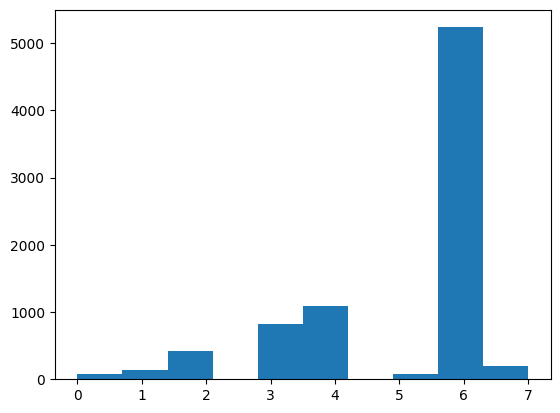

In [18]:
plt.hist(y)

In [10]:
lrm = LogisticRegression()
lrm.fit(X, y)
y_p = lrm.predict(X)

             0         1         2         3         4         5         6  \
0     0.007455  0.023504  0.073360  0.139425  0.216374  0.012825  0.475590   
1     0.008022  0.022724  0.063674  0.131283  0.153056  0.015512  0.559859   
2     0.014263  0.014836  0.019408  0.069187  0.052840  0.005231  0.815867   
3     0.006882  0.013833  0.025662  0.075907  0.055693  0.004169  0.811408   
4     0.004236  0.023763  0.088309  0.102610  0.205378  0.024162  0.494449   
...        ...       ...       ...       ...       ...       ...       ...   
8063  0.004405  0.017738  0.110331  0.097576  0.359212  0.014839  0.382423   
8064  0.007121  0.014270  0.058246  0.098287  0.178705  0.009616  0.572363   
8065  0.013147  0.025751  0.059368  0.122480  0.054810  0.010700  0.713290   
8066  0.005643  0.024838  0.113858  0.134389  0.125577  0.023005  0.532876   
8067  0.005945  0.020212  0.059403  0.123071  0.115180  0.008374  0.636436   

             7  res  
0     0.030103    6  
1     0.033321    6

In [11]:
y_p

0       6
1       6
2       6
3       6
4       6
       ..
8063    6
8064    6
8065    6
8066    6
8067    6
Name: res, Length: 8068, dtype: int64

In [12]:
cm = utl.confusion_matrix(y, y_p)
acc = utl.accuracy_classification(cm)
pres = utl.presicion_classification(cm)
rec = utl.recall_classification(cm)
f1 = utl.fbeta_classification(cm)

e:\JupyterNotebooks\2023\ML Models\MLModels\notebooks\../scripts\utils.py:126: RuntimeWarning: invalid value encountered in scalar divide
  return cm[i][i]/cm[:,i].sum()


In [13]:
np.set_printoptions(formatter={'float_kind':'{:4.0f}'.format})
cm

array([[   0,    0,    0,    0,    1,    0,   75,    0],
       [   0,    0,    0,    0,    1,    0,  132,    0],
       [   0,    0,    0,    0,   15,    0,  407,    0],
       [   0,    0,    0,    0,   20,    0,  802,    0],
       [   0,    0,    0,    0,   54,    0, 1035,    0],
       [   0,    0,    0,    0,    5,    0,   80,    0],
       [   0,    0,    0,    0,   41,    0, 5197,    0],
       [   0,    0,    0,    0,    5,    0,  198,    0]])

In [14]:
acc, pres, rec, f1

(0.6508428358948934, 0.0, nan, nan)

## Comparison with scikit learn

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
clf = LogisticRegression(random_state=0).fit(X,y)
y_pred_skl_np = clf.predict(X)
y_pred_skl = pd.Series(y_pred_skl_np)

c:\Users\an2fe\anaconda3\envs\mlmodels\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
cm_skl = utl.confusion_matrix(y, y_pred_skl)
acc_skl = utl.accuracy_classification(cm_skl)
pres_skl = utl.presicion_classification(cm_skl)
rec_skl = utl.recall_classification(cm_skl)
f1_skl = utl.fbeta_classification(cm_skl)

acc_skl, pres_skl, rec_skl, f1_skl

e:\JupyterNotebooks\2023\ML Models\MLModels\notebooks\../scripts\utils.py:126: RuntimeWarning: invalid value encountered in scalar divide
  return cm[i][i]/cm[:,i].sum()


(0.6512146752602875, 0.0, nan, nan)

In [23]:
cm_skl

array([[   0,    0,    0,    0,    2,    0,   74,    0],
       [   0,    0,    0,    0,    1,    0,  132,    0],
       [   0,    0,    0,    0,   16,    0,  406,    0],
       [   0,    0,    0,    0,   20,    0,  802,    0],
       [   0,    0,    0,    0,   55,    0, 1034,    0],
       [   0,    0,    0,    0,    4,    0,   81,    0],
       [   0,    0,    0,    0,   39,    0, 5199,    0],
       [   0,    0,    0,    0,    5,    0,  198,    0]])